#Few-shot learning: ejemplo sencillo

## **Seno**

El modelo es rápido y muy preciso. 10 puntos de entrenamiento.

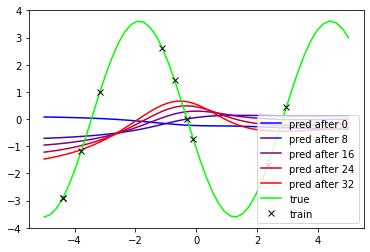

-----------------------------
iteration               1
loss on plotted curve   6.585


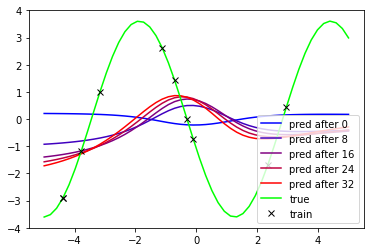

-----------------------------
iteration               1000
loss on plotted curve   6.240


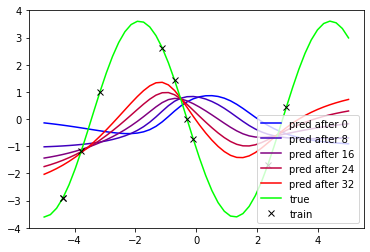

-----------------------------
iteration               2000
loss on plotted curve   3.570


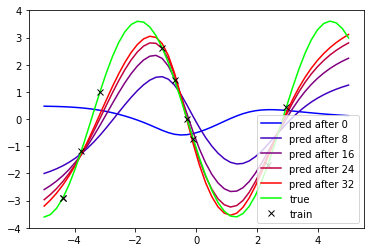

-----------------------------
iteration               3000
loss on plotted curve   0.341


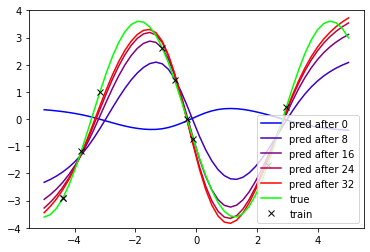

-----------------------------
iteration               4000
loss on plotted curve   0.149


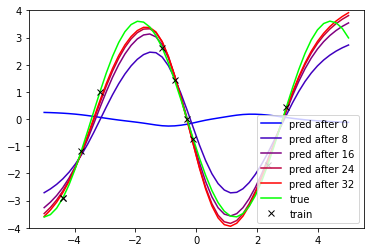

-----------------------------
iteration               5000
loss on plotted curve   0.101


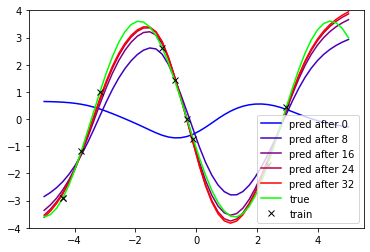

-----------------------------
iteration               6000
loss on plotted curve   0.074


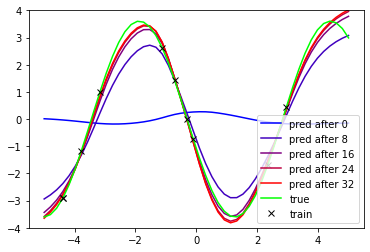

-----------------------------
iteration               7000
loss on plotted curve   0.061


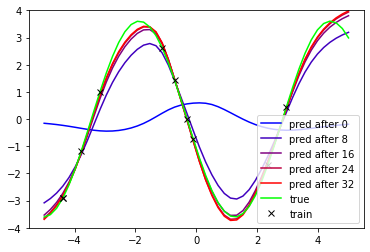

-----------------------------
iteration               8000
loss on plotted curve   0.050


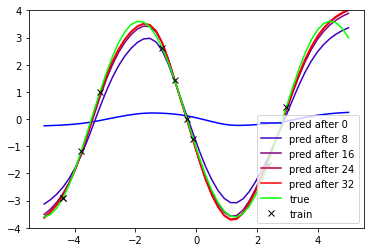

-----------------------------
iteration               9000
loss on plotted curve   0.048


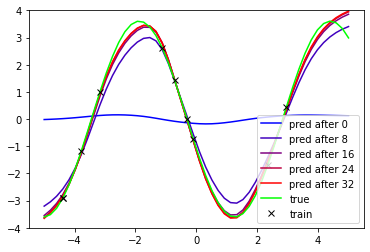

-----------------------------
iteration               10000
loss on plotted curve   0.045


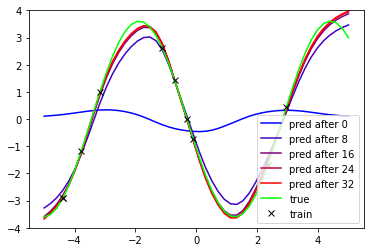

-----------------------------
iteration               11000
loss on plotted curve   0.044


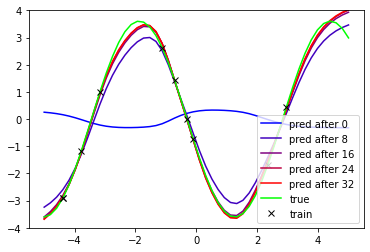

-----------------------------
iteration               12000
loss on plotted curve   0.045


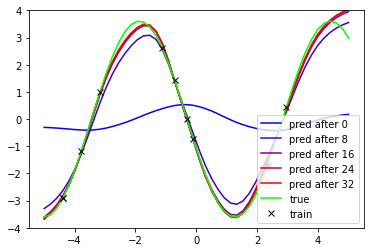

-----------------------------
iteration               13000
loss on plotted curve   0.045


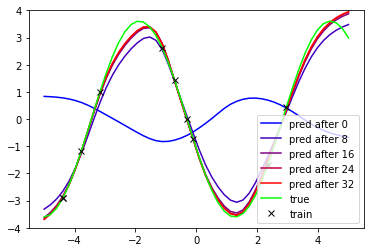

-----------------------------
iteration               14000
loss on plotted curve   0.048


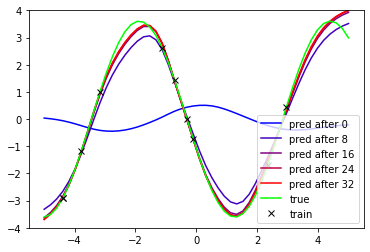

-----------------------------
iteration               15000
loss on plotted curve   0.048


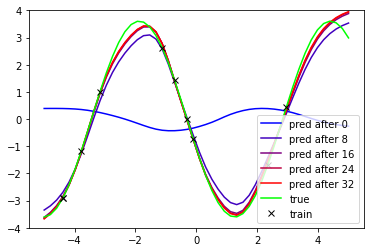

-----------------------------
iteration               16000
loss on plotted curve   0.047


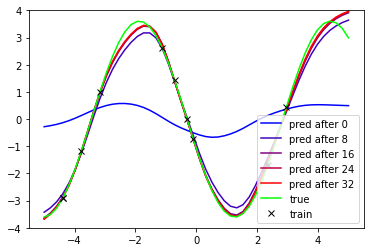

-----------------------------
iteration               17000
loss on plotted curve   0.043


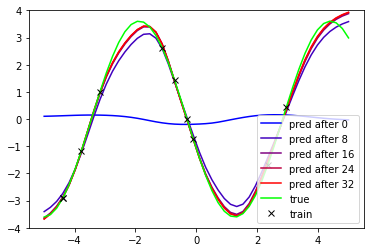

-----------------------------
iteration               18000
loss on plotted curve   0.044


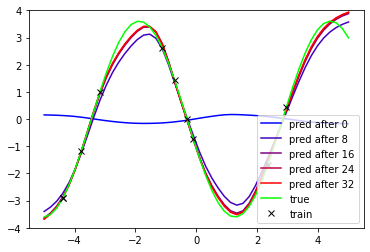

-----------------------------
iteration               19000
loss on plotted curve   0.049


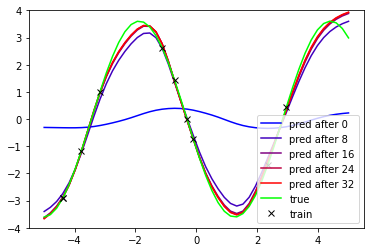

-----------------------------
iteration               20000
loss on plotted curve   0.046


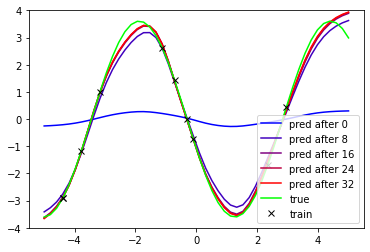

-----------------------------
iteration               21000
loss on plotted curve   0.044


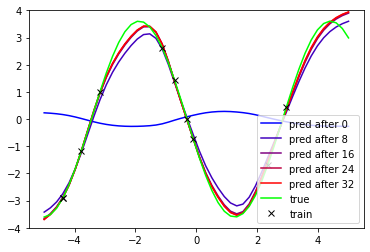

-----------------------------
iteration               22000
loss on plotted curve   0.050


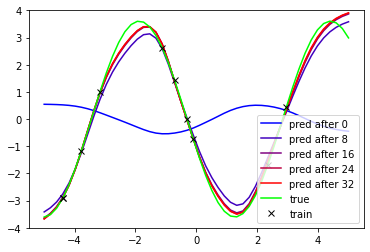

-----------------------------
iteration               23000
loss on plotted curve   0.051


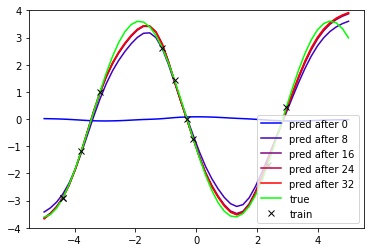

-----------------------------
iteration               24000
loss on plotted curve   0.047


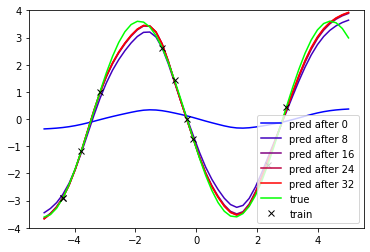

-----------------------------
iteration               25000
loss on plotted curve   0.047


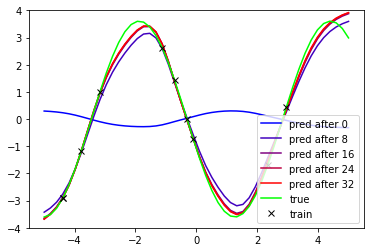

-----------------------------
iteration               26000
loss on plotted curve   0.050


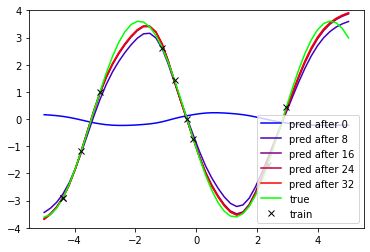

-----------------------------
iteration               27000
loss on plotted curve   0.048


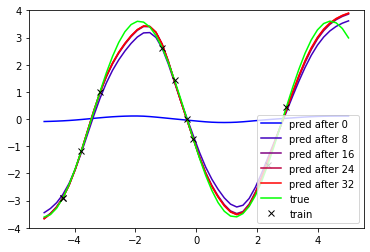

-----------------------------
iteration               28000
loss on plotted curve   0.047


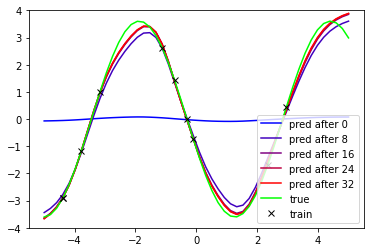

-----------------------------
iteration               29000
loss on plotted curve   0.048


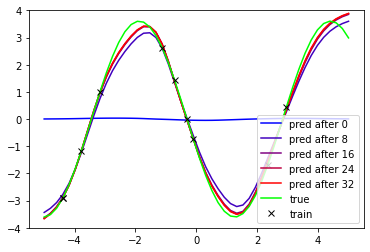

-----------------------------
iteration               30000
loss on plotted curve   0.048


In [1]:
import numpy as np
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
from copy import deepcopy

seed = 0
plot = True
innerstepsize = 0.02 # stepsize in inner SGD
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 30000 # number of outer updates; each iteration we sample one task and update on it

rng = np.random.RandomState(seed)
torch.manual_seed(seed)

# Define task distribution
x_all = np.linspace(-5, 5, 50)[:,None] # All of the x points
ntrain = 10 # Size of training minibatches //El algoritmo verá diez pares (x,y)
def gen_task():
    "Generate classification problem"
    phase = rng.uniform(low=0, high=2*np.pi)
    ampl = rng.uniform(0.1, 5)
    f_randomsine = lambda x : np.sin(x + phase) * ampl
    return f_randomsine

# Define model. Reptile paper uses ReLU, but Tanh gives slightly better results
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
)

def totorch(x):
    return ag.Variable(torch.Tensor(x))

def train_on_batch(x, y):
    x = totorch(x)
    y = totorch(y)
    model.zero_grad()
    ypred = model(x)
    loss = (ypred - y).pow(2).mean()
    loss.backward()
    for param in model.parameters():
        param.data -= innerstepsize * param.grad.data

def predict(x):
    x = totorch(x)
    return model(x).data.numpy()

# Choose a fixed task and minibatch for visualization
f_plot = gen_task()
xtrain_plot = x_all[rng.choice(len(x_all), size=ntrain)]

# Reptile training loop
for iteration in range(niterations):
    weights_before = deepcopy(model.state_dict())
    # Generate task
    f = gen_task()
    y_all = f(x_all)
    # Do SGD on this task
    inds = rng.permutation(len(x_all))
    for _ in range(innerepochs):
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds])
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
    weights_after = model.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule
    model.load_state_dict({name : 
        weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
        for name in weights_before})

    # Periodically plot the results on a particular task and minibatch
    if plot and iteration==0 or (iteration+1) % 1000 == 0:
        plt.cla()
        f = f_plot
        weights_before = deepcopy(model.state_dict()) # save snapshot before evaluation
        plt.plot(x_all, predict(x_all), label="pred after 0", color=(0,0,1))
        for inneriter in range(32):
            train_on_batch(xtrain_plot, f(xtrain_plot))
            if (inneriter+1) % 8 == 0:
                frac = (inneriter+1) / 32
                plt.plot(x_all, predict(x_all), label="pred after %i"%(inneriter+1), color=(frac, 0, 1-frac))
        plt.plot(x_all, f(x_all), label="true", color=(0,1,0))
        lossval = np.square(predict(x_all) - f(x_all)).mean()
        plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
        plt.ylim(-4,4)
        plt.legend(loc="lower right")
        plt.pause(0.01)
        model.load_state_dict(weights_before) # restore from snapshot
        print(f"-----------------------------")
        print(f"iteration               {iteration+1}")
        print(f"loss on plotted curve   {lossval:.3f}") # would be better to average loss over a set of examples, but this is optimized for brevity

## **Coseno**

El algoritmo es eficiente, tarda 2 min y 4 seg en dar una predicción y no requiere de GPU. \\
Por otro lado, vemos que no alcanza los niveles de precisión que alcanza con el seno. **texto en negrita**


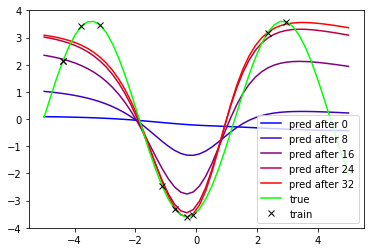

-----------------------------
iteration               1
loss on plotted curve   2.494


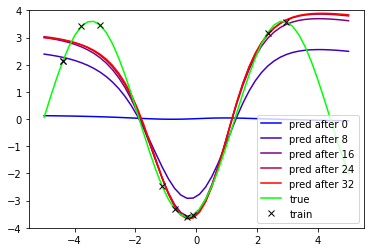

-----------------------------
iteration               1000
loss on plotted curve   2.804


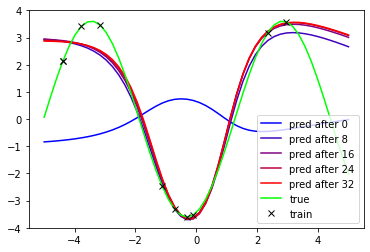

-----------------------------
iteration               2000
loss on plotted curve   2.157


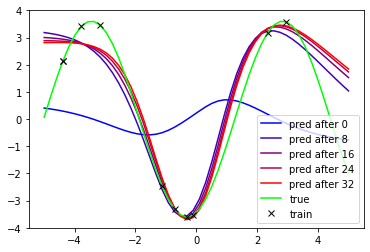

-----------------------------
iteration               3000
loss on plotted curve   1.394


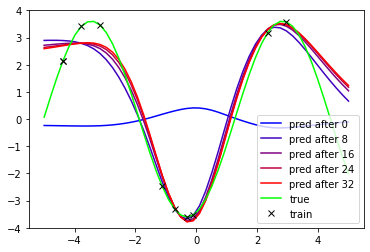

-----------------------------
iteration               4000
loss on plotted curve   0.974


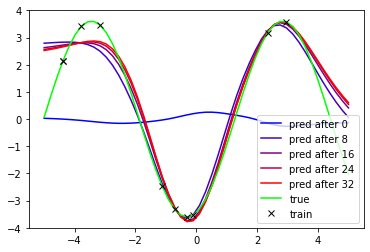

-----------------------------
iteration               5000
loss on plotted curve   0.680


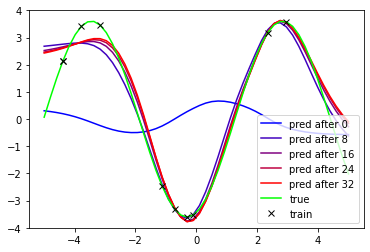

-----------------------------
iteration               6000
loss on plotted curve   0.438


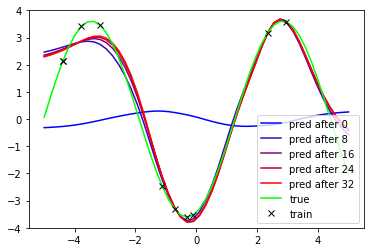

-----------------------------
iteration               7000
loss on plotted curve   0.359


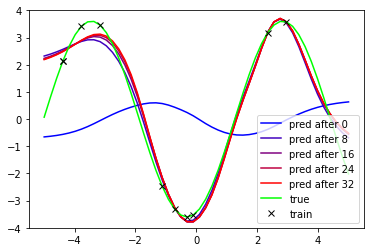

-----------------------------
iteration               8000
loss on plotted curve   0.334


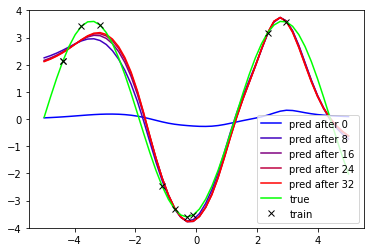

-----------------------------
iteration               9000
loss on plotted curve   0.335


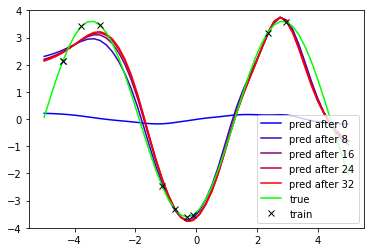

-----------------------------
iteration               10000
loss on plotted curve   0.313


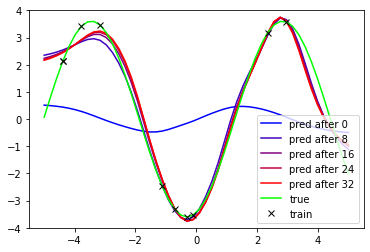

-----------------------------
iteration               11000
loss on plotted curve   0.310


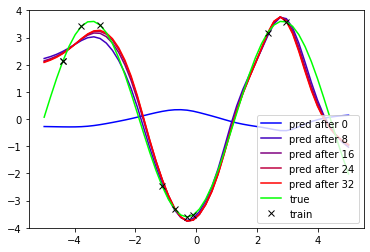

-----------------------------
iteration               12000
loss on plotted curve   0.309


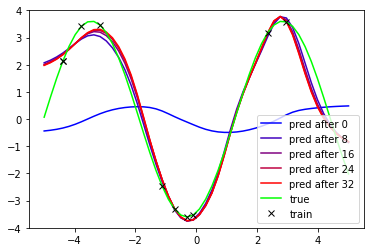

-----------------------------
iteration               13000
loss on plotted curve   0.312


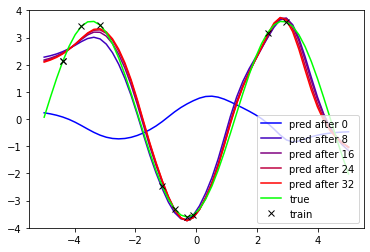

-----------------------------
iteration               14000
loss on plotted curve   0.289


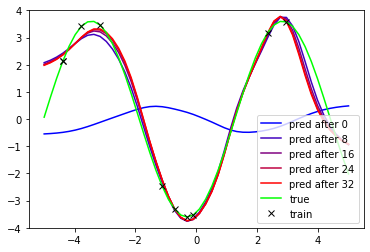

-----------------------------
iteration               15000
loss on plotted curve   0.307


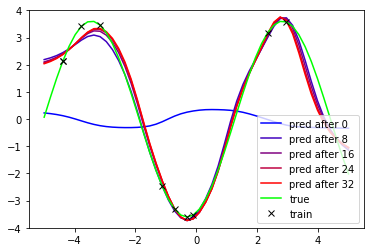

-----------------------------
iteration               16000
loss on plotted curve   0.300


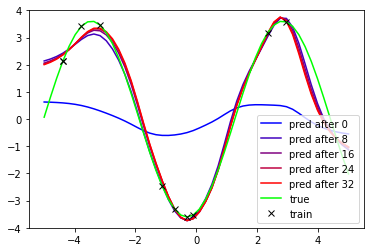

-----------------------------
iteration               17000
loss on plotted curve   0.294


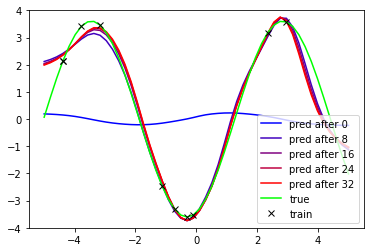

-----------------------------
iteration               18000
loss on plotted curve   0.290


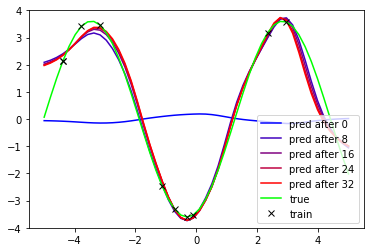

-----------------------------
iteration               19000
loss on plotted curve   0.281


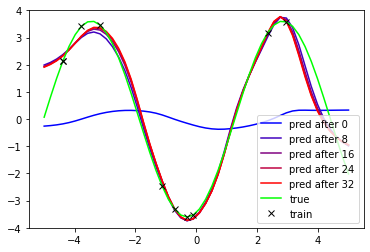

-----------------------------
iteration               20000
loss on plotted curve   0.295


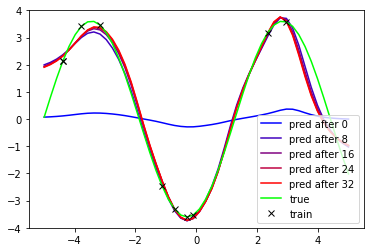

-----------------------------
iteration               21000
loss on plotted curve   0.285


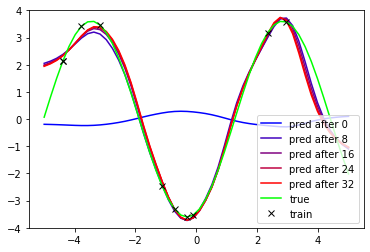

-----------------------------
iteration               22000
loss on plotted curve   0.278


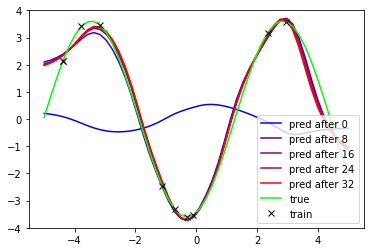

-----------------------------
iteration               23000
loss on plotted curve   0.247


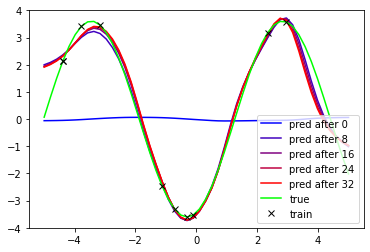

-----------------------------
iteration               24000
loss on plotted curve   0.260


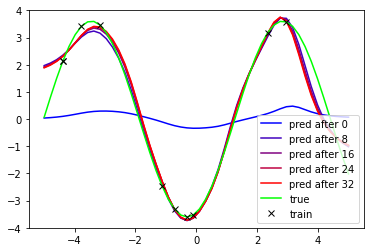

-----------------------------
iteration               25000
loss on plotted curve   0.278


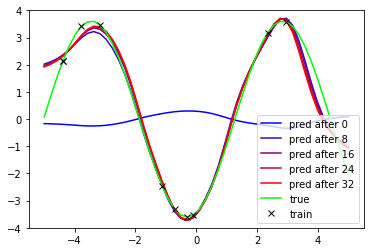

-----------------------------
iteration               26000
loss on plotted curve   0.262


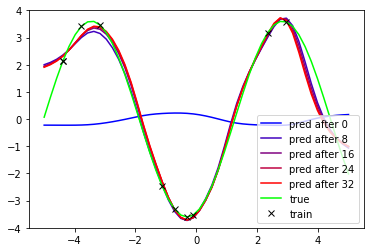

-----------------------------
iteration               27000
loss on plotted curve   0.268


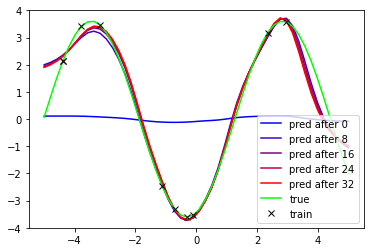

-----------------------------
iteration               28000
loss on plotted curve   0.263


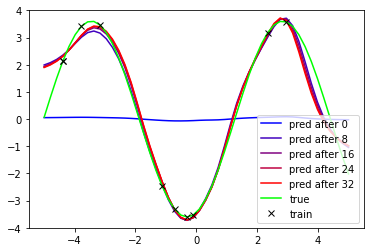

-----------------------------
iteration               29000
loss on plotted curve   0.261


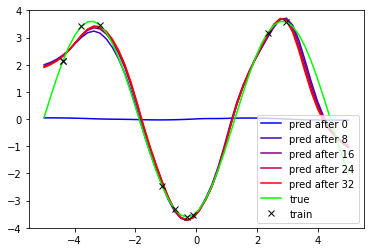

-----------------------------
iteration               30000
loss on plotted curve   0.255


In [2]:
import numpy as np
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
from copy import deepcopy

seed = 0
plot = True
innerstepsize = 0.02 # stepsize in inner SGD
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 30000 # number of outer updates; each iteration we sample one task and update on it

rng = np.random.RandomState(seed)
torch.manual_seed(seed)

# Define task distribution
x_all = np.linspace(-5, 5, 50)[:,None] # All of the x points
ntrain = 10 # Size of training minibatches
def gen_task():
    "Generate classification problem"
    phase = rng.uniform(low=0, high=2*np.pi)
    ampl = rng.uniform(0.1, 5)
    f_randomcosine = lambda x : np.cos(x + phase) * ampl
    return f_randomcosine

# Define model. Reptile paper uses ReLU, but Tanh gives slightly better results
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
)

def totorch(x):
    return ag.Variable(torch.Tensor(x))

def train_on_batch(x, y):
    x = totorch(x)
    y = totorch(y)
    model.zero_grad()
    ypred = model(x)
    loss = (ypred - y).pow(2).mean()
    loss.backward()
    for param in model.parameters():
        param.data -= innerstepsize * param.grad.data

def predict(x):
    x = totorch(x)
    return model(x).data.numpy()

# Choose a fixed task and minibatch for visualization
f_plot = gen_task()
xtrain_plot = x_all[rng.choice(len(x_all), size=ntrain)]

# Reptile training loop
for iteration in range(niterations):
    weights_before = deepcopy(model.state_dict())
    # Generate task
    f = gen_task()
    y_all = f(x_all)
    # Do SGD on this task
    inds = rng.permutation(len(x_all))
    for _ in range(innerepochs):
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds])
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
    weights_after = model.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule
    model.load_state_dict({name : 
        weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
        for name in weights_before})

    # Periodically plot the results on a particular task and minibatch
    if plot and iteration==0 or (iteration+1) % 1000 == 0:
        plt.cla()
        f = f_plot
        weights_before = deepcopy(model.state_dict()) # save snapshot before evaluation
        plt.plot(x_all, predict(x_all), label="pred after 0", color=(0,0,1))
        for inneriter in range(32):
            train_on_batch(xtrain_plot, f(xtrain_plot))
            if (inneriter+1) % 8 == 0:
                frac = (inneriter+1) / 32
                plt.plot(x_all, predict(x_all), label="pred after %i"%(inneriter+1), color=(frac, 0, 1-frac))
        plt.plot(x_all, f(x_all), label="true", color=(0,1,0))
        lossval = np.square(predict(x_all) - f(x_all)).mean()
        plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
        plt.ylim(-4,4)
        plt.legend(loc="lower right")
        plt.pause(0.01)
        model.load_state_dict(weights_before) # restore from snapshot
        print(f"-----------------------------")
        print(f"iteration               {iteration+1}")
        print(f"loss on plotted curve   {lossval:.3f}") # would be better to average loss over a set of examples, but this is optimized for brevity

## **Seno pero con menos puntos disponibles**

El modelo es más tardado, pero sigue siendo muy preciso. 5 puntos de entrenamiento. Tardó 3 m in y 25 seg sin necesidad de utilizar GPU.

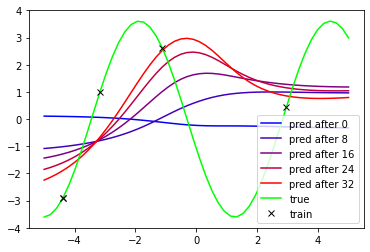

-----------------------------
iteration               1
loss on plotted curve   8.079


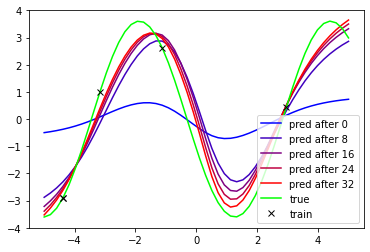

-----------------------------
iteration               1000
loss on plotted curve   0.323


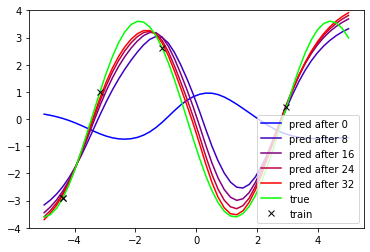

-----------------------------
iteration               2000
loss on plotted curve   0.105


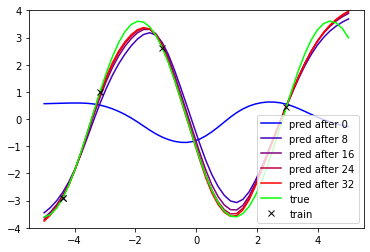

-----------------------------
iteration               3000
loss on plotted curve   0.065


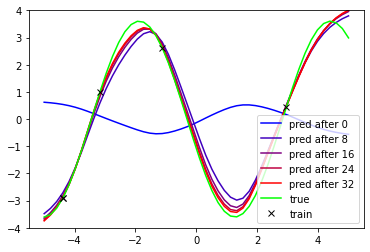

-----------------------------
iteration               4000
loss on plotted curve   0.074


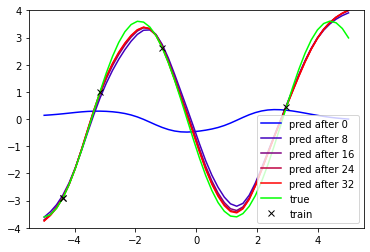

-----------------------------
iteration               5000
loss on plotted curve   0.073


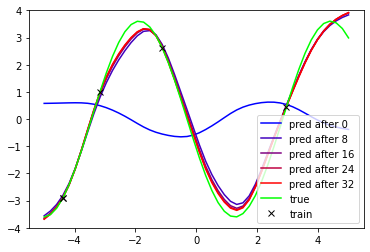

-----------------------------
iteration               6000
loss on plotted curve   0.078


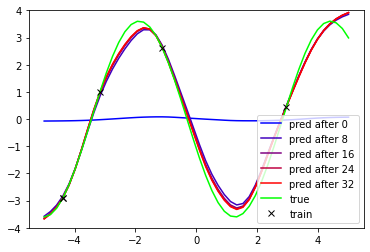

-----------------------------
iteration               7000
loss on plotted curve   0.083


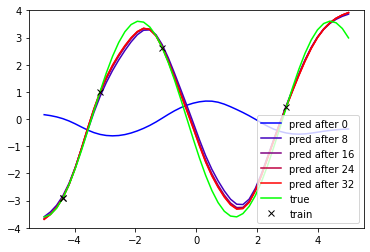

-----------------------------
iteration               8000
loss on plotted curve   0.094


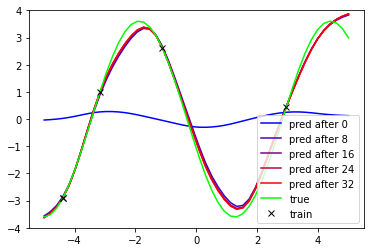

-----------------------------
iteration               9000
loss on plotted curve   0.073


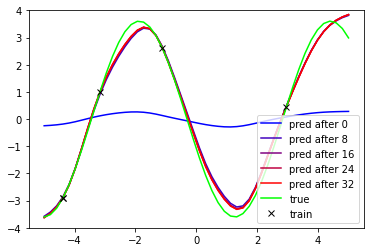

-----------------------------
iteration               10000
loss on plotted curve   0.078


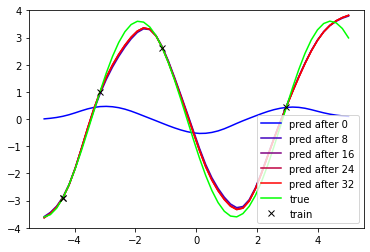

-----------------------------
iteration               11000
loss on plotted curve   0.079


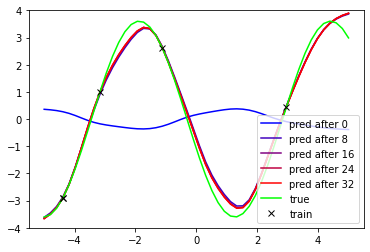

-----------------------------
iteration               12000
loss on plotted curve   0.089


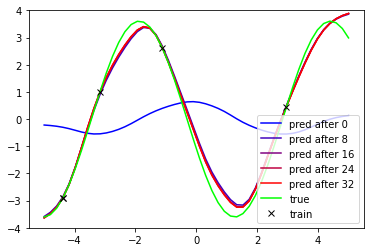

-----------------------------
iteration               13000
loss on plotted curve   0.100


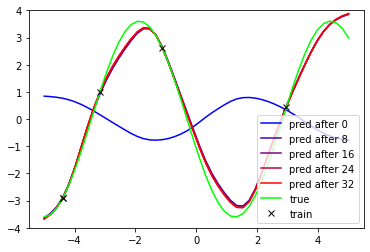

-----------------------------
iteration               14000
loss on plotted curve   0.108


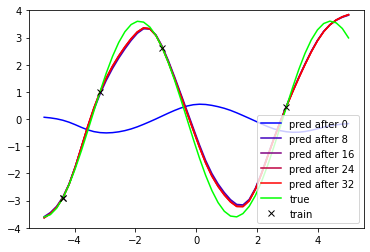

-----------------------------
iteration               15000
loss on plotted curve   0.106


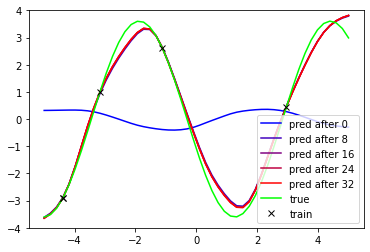

-----------------------------
iteration               16000
loss on plotted curve   0.103


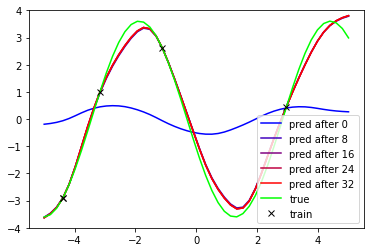

-----------------------------
iteration               17000
loss on plotted curve   0.089


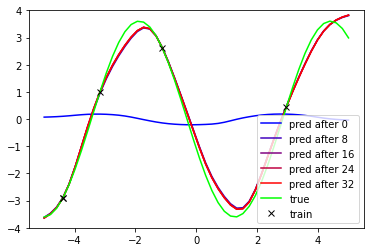

-----------------------------
iteration               18000
loss on plotted curve   0.088


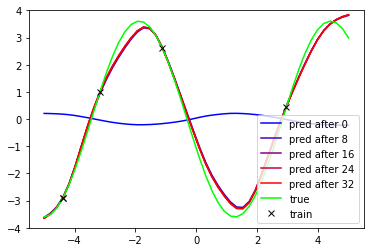

-----------------------------
iteration               19000
loss on plotted curve   0.093


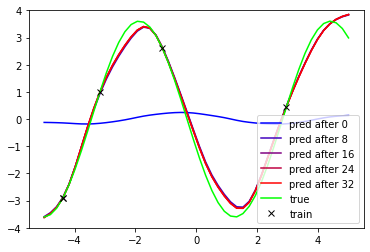

-----------------------------
iteration               20000
loss on plotted curve   0.090


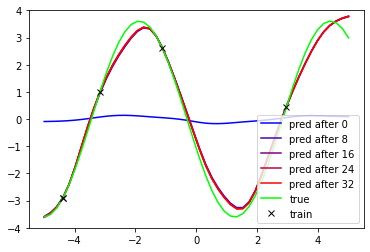

-----------------------------
iteration               21000
loss on plotted curve   0.082


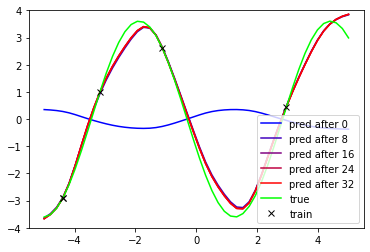

-----------------------------
iteration               22000
loss on plotted curve   0.097


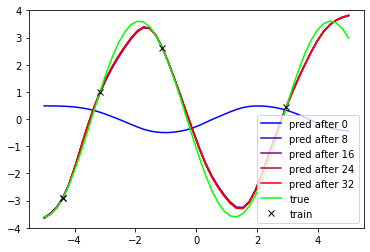

-----------------------------
iteration               23000
loss on plotted curve   0.093


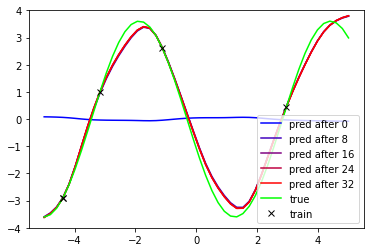

-----------------------------
iteration               24000
loss on plotted curve   0.088


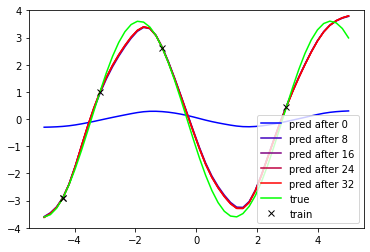

-----------------------------
iteration               25000
loss on plotted curve   0.089


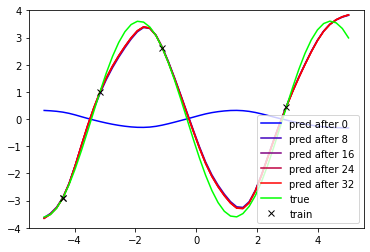

-----------------------------
iteration               26000
loss on plotted curve   0.097


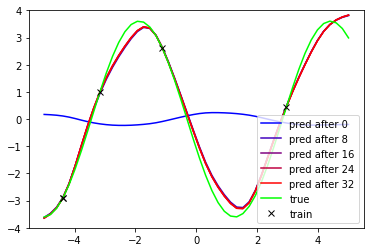

-----------------------------
iteration               27000
loss on plotted curve   0.095


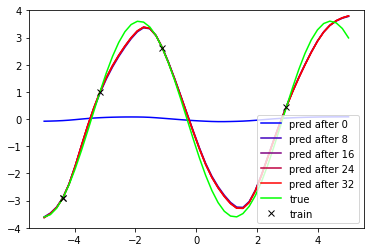

-----------------------------
iteration               28000
loss on plotted curve   0.091


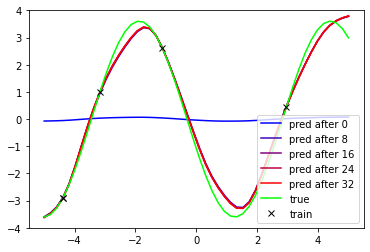

-----------------------------
iteration               29000
loss on plotted curve   0.091


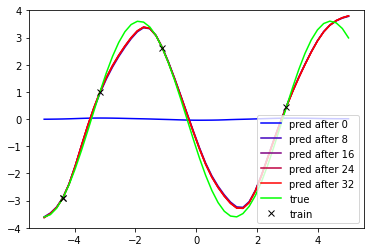

-----------------------------
iteration               30000
loss on plotted curve   0.091


In [3]:
import numpy as np
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
from copy import deepcopy

seed = 0
plot = True
innerstepsize = 0.02 # stepsize in inner SGD
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 30000 # number of outer updates; each iteration we sample one task and update on it

rng = np.random.RandomState(seed)
torch.manual_seed(seed)

# Define task distribution
x_all = np.linspace(-5, 5, 50)[:,None] # All of the x points
ntrain = 5 # Size of training minibatches
def gen_task():
    "Generate classification problem"
    phase = rng.uniform(low=0, high=2*np.pi)
    ampl = rng.uniform(0.1, 5)
    f_randomsine = lambda x : np.sin(x + phase) * ampl
    return f_randomsine

# Define model. Reptile paper uses ReLU, but Tanh gives slightly better results
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
)

def totorch(x):
    return ag.Variable(torch.Tensor(x))

def train_on_batch(x, y):
    x = totorch(x)
    y = totorch(y)
    model.zero_grad()
    ypred = model(x)
    loss = (ypred - y).pow(2).mean()
    loss.backward()
    for param in model.parameters():
        param.data -= innerstepsize * param.grad.data

def predict(x):
    x = totorch(x)
    return model(x).data.numpy()

# Choose a fixed task and minibatch for visualization
f_plot = gen_task()
xtrain_plot = x_all[rng.choice(len(x_all), size=ntrain)]

# Reptile training loop
for iteration in range(niterations):
    weights_before = deepcopy(model.state_dict())
    # Generate task
    f = gen_task()
    y_all = f(x_all)
    # Do SGD on this task
    inds = rng.permutation(len(x_all))
    for _ in range(innerepochs):
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds])
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
    weights_after = model.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule
    model.load_state_dict({name : 
        weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
        for name in weights_before})

    # Periodically plot the results on a particular task and minibatch
    if plot and iteration==0 or (iteration+1) % 1000 == 0:
        plt.cla()
        f = f_plot
        weights_before = deepcopy(model.state_dict()) # save snapshot before evaluation
        plt.plot(x_all, predict(x_all), label="pred after 0", color=(0,0,1))
        for inneriter in range(32):
            train_on_batch(xtrain_plot, f(xtrain_plot))
            if (inneriter+1) % 8 == 0:
                frac = (inneriter+1) / 32
                plt.plot(x_all, predict(x_all), label="pred after %i"%(inneriter+1), color=(frac, 0, 1-frac))
        plt.plot(x_all, f(x_all), label="true", color=(0,1,0))
        lossval = np.square(predict(x_all) - f(x_all)).mean()
        plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
        plt.ylim(-4,4)
        plt.legend(loc="lower right")
        plt.pause(0.01)
        model.load_state_dict(weights_before) # restore from snapshot
        print(f"-----------------------------")
        print(f"iteration               {iteration+1}")
        print(f"loss on plotted curve   {lossval:.3f}") # would be better to average loss over a set of examples, but this is optimized for brevity

## **Coseno pero con menos puntos disponibles**
Tardó 3 min con 22 seg. No requiere de uso de GPU.

5 puntos de entrenamiento. 

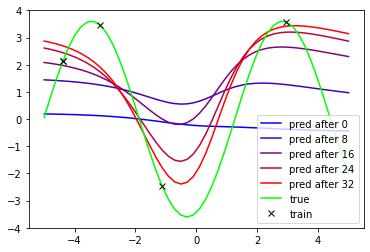

-----------------------------
iteration               1
loss on plotted curve   2.885


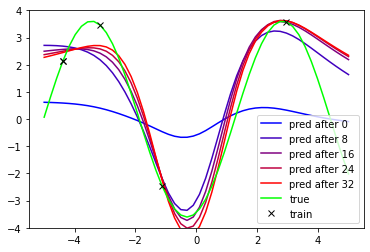

-----------------------------
iteration               1000
loss on plotted curve   1.596


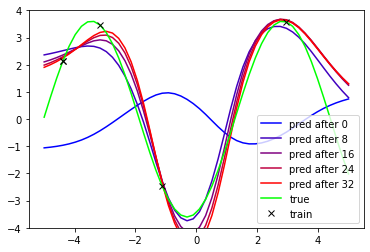

-----------------------------
iteration               2000
loss on plotted curve   1.118


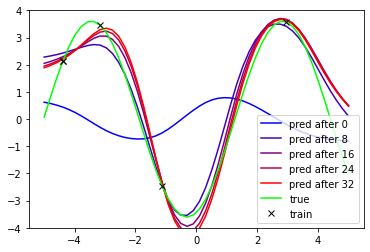

-----------------------------
iteration               3000
loss on plotted curve   0.661


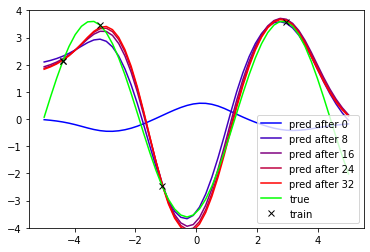

-----------------------------
iteration               4000
loss on plotted curve   0.466


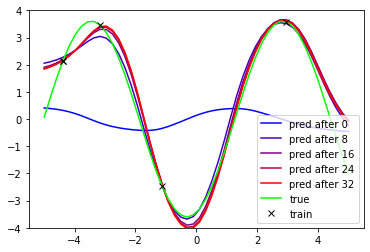

-----------------------------
iteration               5000
loss on plotted curve   0.390


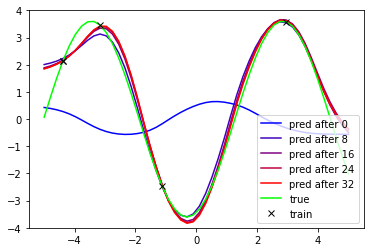

-----------------------------
iteration               6000
loss on plotted curve   0.278


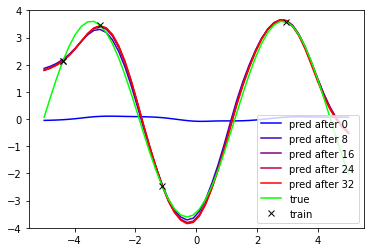

-----------------------------
iteration               7000
loss on plotted curve   0.221


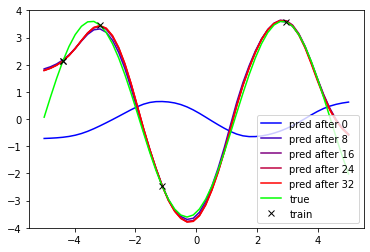

-----------------------------
iteration               8000
loss on plotted curve   0.199


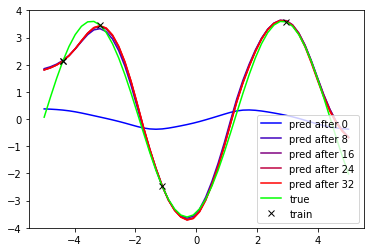

-----------------------------
iteration               9000
loss on plotted curve   0.198


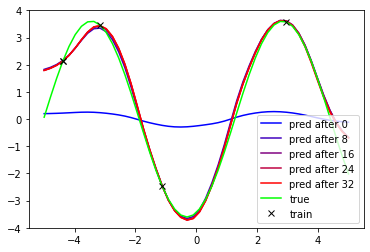

-----------------------------
iteration               10000
loss on plotted curve   0.182


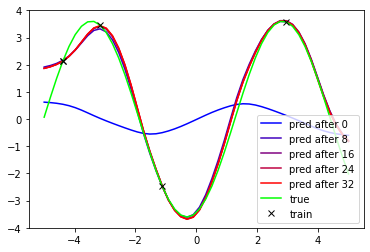

-----------------------------
iteration               11000
loss on plotted curve   0.189


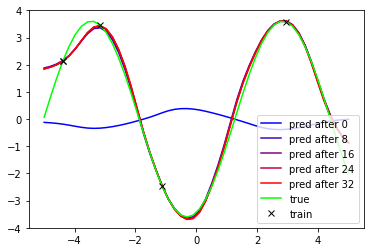

-----------------------------
iteration               12000
loss on plotted curve   0.168


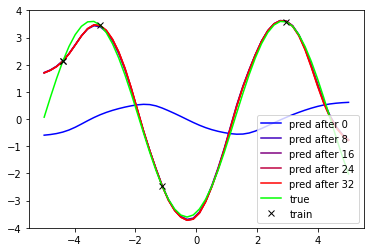

-----------------------------
iteration               13000
loss on plotted curve   0.144


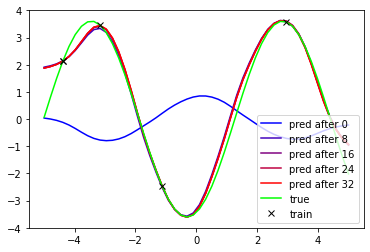

-----------------------------
iteration               14000
loss on plotted curve   0.187


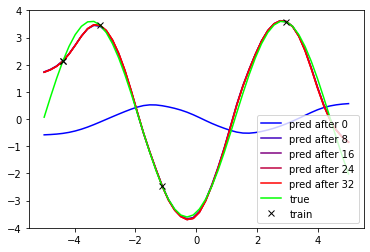

-----------------------------
iteration               15000
loss on plotted curve   0.142


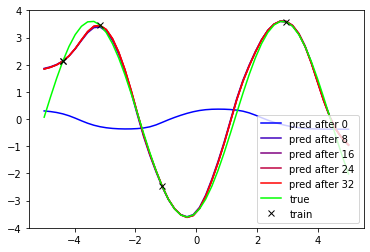

-----------------------------
iteration               16000
loss on plotted curve   0.165


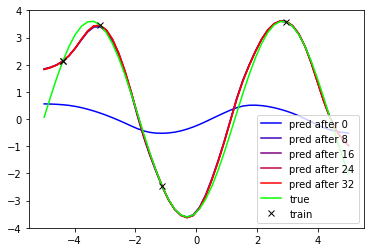

-----------------------------
iteration               17000
loss on plotted curve   0.163


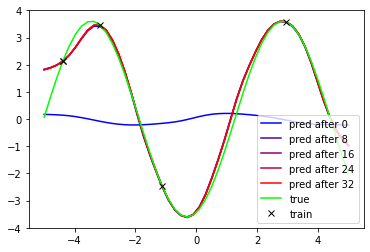

-----------------------------
iteration               18000
loss on plotted curve   0.162


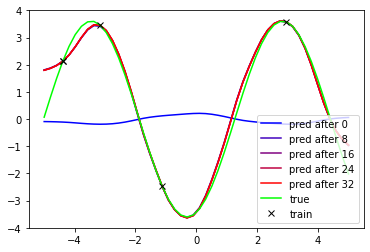

-----------------------------
iteration               19000
loss on plotted curve   0.152


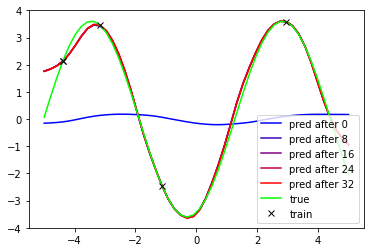

-----------------------------
iteration               20000
loss on plotted curve   0.138


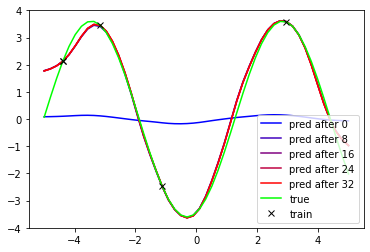

-----------------------------
iteration               21000
loss on plotted curve   0.144


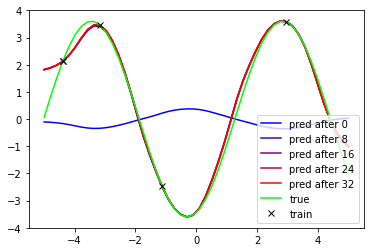

-----------------------------
iteration               22000
loss on plotted curve   0.152


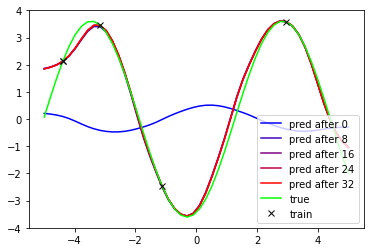

-----------------------------
iteration               23000
loss on plotted curve   0.168


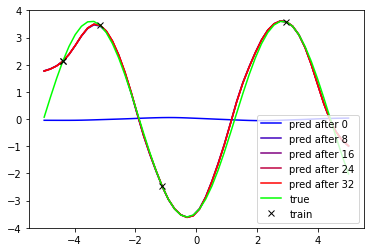

-----------------------------
iteration               24000
loss on plotted curve   0.139


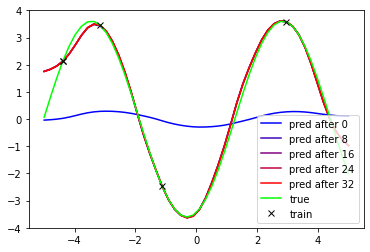

-----------------------------
iteration               25000
loss on plotted curve   0.134


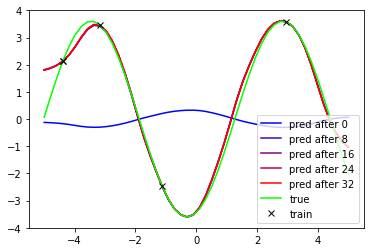

-----------------------------
iteration               26000
loss on plotted curve   0.149


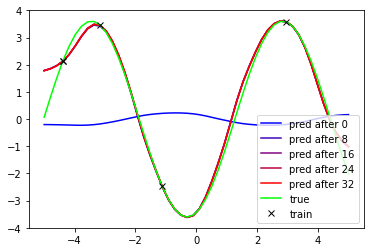

-----------------------------
iteration               27000
loss on plotted curve   0.142


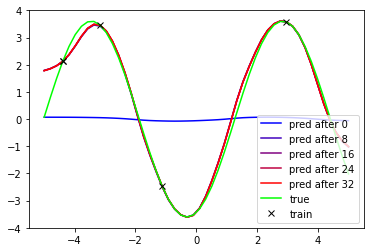

-----------------------------
iteration               28000
loss on plotted curve   0.142


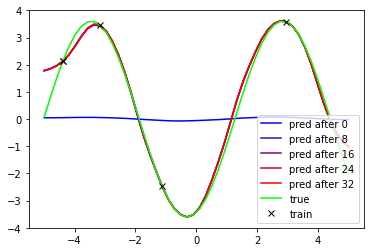

-----------------------------
iteration               29000
loss on plotted curve   0.143


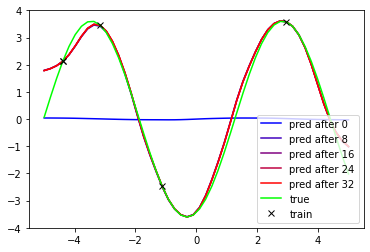

-----------------------------
iteration               30000
loss on plotted curve   0.145


In [4]:
import numpy as np
import torch
from torch import nn, autograd as ag
import matplotlib.pyplot as plt
from copy import deepcopy

seed = 0
plot = True
innerstepsize = 0.02 # stepsize in inner SGD
innerepochs = 1 # number of epochs of each inner SGD
outerstepsize0 = 0.1 # stepsize of outer optimization, i.e., meta-optimization
niterations = 30000 # number of outer updates; each iteration we sample one task and update on it

rng = np.random.RandomState(seed)
torch.manual_seed(seed)

# Define task distribution
x_all = np.linspace(-5, 5, 50)[:,None] # All of the x points
ntrain = 5 # Size of training minibatches
def gen_task():
    "Generate classification problem"
    phase = rng.uniform(low=0, high=2*np.pi)
    ampl = rng.uniform(0.1, 5)
    f_randomcosine = lambda x : np.cos(x + phase) * ampl
    return f_randomcosine

# Define model. Reptile paper uses ReLU, but Tanh gives slightly better results
model = nn.Sequential(
    nn.Linear(1, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
)

def totorch(x):
    return ag.Variable(torch.Tensor(x))

def train_on_batch(x, y):
    x = totorch(x)
    y = totorch(y)
    model.zero_grad()
    ypred = model(x)
    loss = (ypred - y).pow(2).mean()
    loss.backward()
    for param in model.parameters():
        param.data -= innerstepsize * param.grad.data

def predict(x):
    x = totorch(x)
    return model(x).data.numpy()

# Choose a fixed task and minibatch for visualization
f_plot = gen_task()
xtrain_plot = x_all[rng.choice(len(x_all), size=ntrain)]

# Reptile training loop
for iteration in range(niterations):
    weights_before = deepcopy(model.state_dict())
    # Generate task
    f = gen_task()
    y_all = f(x_all)
    # Do SGD on this task
    inds = rng.permutation(len(x_all))
    for _ in range(innerepochs):
        for start in range(0, len(x_all), ntrain):
            mbinds = inds[start:start+ntrain]
            train_on_batch(x_all[mbinds], y_all[mbinds])
    # Interpolate between current weights and trained weights from this task
    # I.e. (weights_before - weights_after) is the meta-gradient
    weights_after = model.state_dict()
    outerstepsize = outerstepsize0 * (1 - iteration / niterations) # linear schedule
    model.load_state_dict({name : 
        weights_before[name] + (weights_after[name] - weights_before[name]) * outerstepsize 
        for name in weights_before})

    # Periodically plot the results on a particular task and minibatch
    if plot and iteration==0 or (iteration+1) % 1000 == 0:
        plt.cla()
        f = f_plot
        weights_before = deepcopy(model.state_dict()) # save snapshot before evaluation
        plt.plot(x_all, predict(x_all), label="pred after 0", color=(0,0,1))
        for inneriter in range(32):
            train_on_batch(xtrain_plot, f(xtrain_plot))
            if (inneriter+1) % 8 == 0:
                frac = (inneriter+1) / 32
                plt.plot(x_all, predict(x_all), label="pred after %i"%(inneriter+1), color=(frac, 0, 1-frac))
        plt.plot(x_all, f(x_all), label="true", color=(0,1,0))
        lossval = np.square(predict(x_all) - f(x_all)).mean()
        plt.plot(xtrain_plot, f(xtrain_plot), "x", label="train", color="k")
        plt.ylim(-4,4)
        plt.legend(loc="lower right")
        plt.pause(0.01)
        model.load_state_dict(weights_before) # restore from snapshot
        print(f"-----------------------------")
        print(f"iteration               {iteration+1}")
        print(f"loss on plotted curve   {lossval:.3f}") # would be better to average loss over a set of examples, but this is optimized for brevity